In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# === Diretório e parâmetros ===
data_dir = r'D:\Main dataset'
img_size = (224, 224)
batch_size = 32
epochs_finetune = 2
total_epochs = 4

In [3]:
# === Data augmentation + normalização ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.1),
])

In [4]:
# === Carregar datasets ===
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 2598 files belonging to 1 classes.
Using 2079 files for training.
Found 2598 files belonging to 1 classes.
Using 519 files for validation.


In [5]:
def process_input(x, y):
    x = tf.cast(x, tf.float32)  # garante tipo float32
    x = preprocess_input(x)  # inclui reescalonamento e normalização
    y = tf.cast(y, tf.float32) / 5.0  # normaliza o rótulo para [0, 1]
    return x, y

train_ds = train_ds.map(process_input).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_input).prefetch(tf.data.AUTOTUNE)

In [6]:
train_ds = train_ds

In [7]:
# === Base model ===
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet')
base_model.trainable = False  # congela no começo

In [8]:
# === Modelo completo ===
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Previsão contínua
])

In [9]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
# === Treinar etapa 1: base congelada ===
print("Treinando com base congelada...")
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs_finetune)

# === Fine-tuning: destrava a base ===
print("Fine-tuning...")
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mse', metrics=['mae'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs - epochs_finetune
)


Treinando com base congelada...
Epoch 1/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.3172 - mae: 0.3749 - val_loss: 0.0068 - val_mae: 0.0638
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.0106 - mae: 0.0796 - val_loss: 0.0038 - val_mae: 0.0469
Fine-tuning...
Epoch 1/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 575s 8s/step - loss: 0.0079 - mae: 0.0670 - val_loss: 0.0032 - val_mae: 0.0435
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 1315s 20s/step - loss: 0.0057 - mae: 0.0581 - val_loss: 0.0031 - val_mae: 0.0422


In [11]:
model.evaluate(val_ds)

# Save the trained model
model.save("image_classifier_model_v2.h5", save_format='tf')

17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0031 - mae: 0.0433


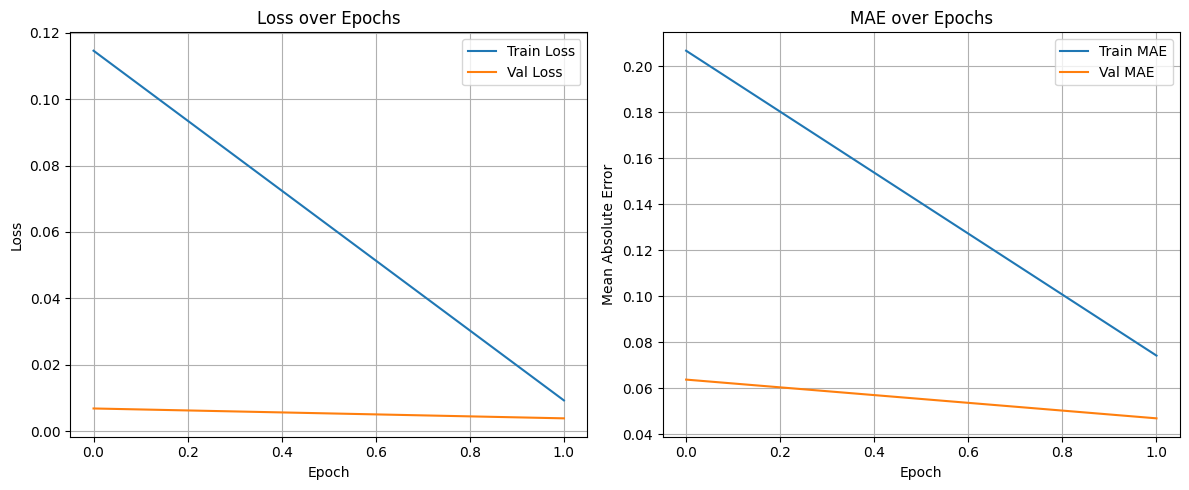

In [12]:
#ARRUMA ISSO AQUI ANTES

import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()